# Style Transfer Notebook

- Based on https://www.tensorflow.org/tutorials/generative/style_transfer?hl=en
- Style transfer paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
tf.__version__

'2.12.0'

## Loading the pre-trained convolutional neural network (VGG19)


In [2]:
network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 0s 0us/step


In [3]:
network.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [4]:
len(network.layers)

22

## Loading and pre-processing the images

### Content image

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
content_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/My Documents/CV-Course/Images/chaves.jpeg')

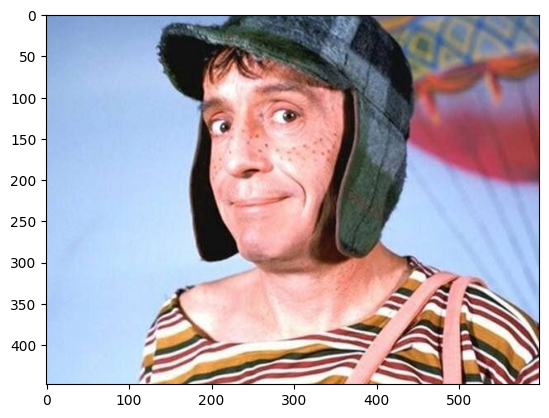

In [7]:
plt.imshow(content_image);

In [8]:
type(content_image)

PIL.JpegImagePlugin.JpegImageFile

In [9]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [10]:
type(content_image), content_image.shape, content_image.min(), content_image.max()

(numpy.ndarray, (448, 598, 3), 0.0, 255.0)

In [11]:
content_image = content_image / 255

In [12]:
content_image.min(), content_image.max()

(0.0, 1.0)

In [13]:
content_image

array([[[0.47843137, 0.6039216 , 0.8039216 ],
        [0.47843137, 0.6039216 , 0.8039216 ],
        [0.47843137, 0.6039216 , 0.8039216 ],
        ...,
        [0.38039216, 0.45882353, 0.5529412 ],
        [0.38039216, 0.45882353, 0.5529412 ],
        [0.38039216, 0.45882353, 0.5529412 ]],

       [[0.4862745 , 0.6117647 , 0.8117647 ],
        [0.4862745 , 0.6117647 , 0.8117647 ],
        [0.4862745 , 0.6117647 , 0.8117647 ],
        ...,
        [0.3882353 , 0.46666667, 0.56078434],
        [0.3882353 , 0.46666667, 0.56078434],
        [0.3882353 , 0.46666667, 0.56078434]],

       [[0.49019608, 0.6156863 , 0.8156863 ],
        [0.49019608, 0.6156863 , 0.8156863 ],
        [0.49019608, 0.6156863 , 0.8156863 ],
        ...,
        [0.3882353 , 0.4745098 , 0.5686275 ],
        [0.3882353 , 0.4745098 , 0.5686275 ],
        [0.3882353 , 0.4745098 , 0.5686275 ]],

       ...,

       [[0.7294118 , 0.8627451 , 1.        ],
        [0.7254902 , 0.85882354, 1.        ],
        [0.7254902 , 0

In [14]:
content_image = content_image[tf.newaxis, :]

In [15]:
content_image.shape

(1, 448, 598, 3)

### Style image

In [16]:
style_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/My Documents/CV-Course/Images/tarsila_amaral.jpg')

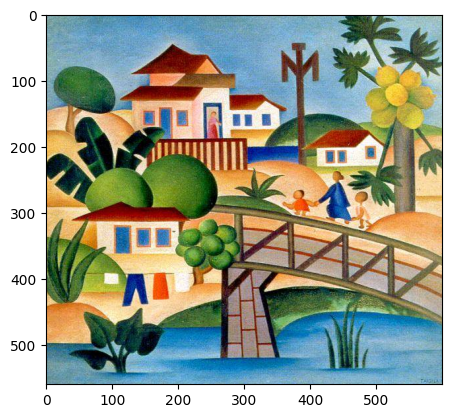

In [17]:
plt.imshow(style_image);

In [18]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 560, 600, 3)

## Building the neural network

In [19]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [22]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(num_content_layers, num_style_layers)

1 5


In [23]:
[network.get_layer(name).output for name in style_layers]

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [24]:
network.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [25]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

  return network

In [26]:
style_extractor = vgg_layers(style_layers)

In [27]:
style_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [28]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [29]:
style_outputs = style_extractor(style_image)

In [30]:
len(style_outputs)

5

In [31]:
style_outputs[1]

<tf.Tensor: shape=(1, 280, 300, 128), dtype=float32, numpy=
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          7.1451001e+00, 0.0000000e+00, 1.2458384e+01],
         [0.0000000e+00, 0.0000000e+00, 1.6780990e+00, ...,
          2.6414452e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 1.1416006e+00, ...,
          5.3857541e+00, 0.0000000e+00, 1.1649476e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 1.7971703e+00, ...,
          5.8314381e+00, 0.0000000e+00, 1.2675024e+00],
         [0.0000000e+00, 0.0000000e+00, 2.0207393e+00, ...,
          6.5748839e+00, 0.0000000e+00, 2.6461110e+00],
         [0.0000000e+00, 0.0000000e+00, 7.9473052e+00, ...,
          1.3143227e+01, 0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 4.9902210e+00, 0.0000000e+00, ...,
          7.3128700e+00, 5.7628554e-01, 1.3347644e+01],
         [0.0000000e+00, 5.0576658e+00, 7.9424836e-02, ...,
          0.0000000e+00, 3.5877305e-01, 0.0000000e+0

In [32]:
style_outputs[0].shape, style_outputs[1].shape, style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape

(TensorShape([1, 560, 600, 64]),
 TensorShape([1, 280, 300, 128]),
 TensorShape([1, 140, 150, 256]),
 TensorShape([1, 70, 75, 512]),
 TensorShape([1, 35, 37, 512]))

In [33]:
# https://www.tensorflow.org/api_docs/python/tf/einsum

# Loss between the style and the content image (see original paper, section 2.2)
def gram_matrix(layer_activation):
  result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation)
  input_shape = tf.shape(layer_activation)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  return result / num_locations

In [34]:
style_outputs[0]

<tf.Tensor: shape=(1, 560, 600, 64), dtype=float32, numpy=
array([[[[0.0000000e+00, 1.0877684e-01, 6.1876789e-02, ...,
          4.7548783e-01, 4.9462211e-01, 1.5644574e-01],
         [0.0000000e+00, 2.0908591e-01, 3.7850654e-01, ...,
          1.7786777e-01, 1.4868841e+00, 1.1423521e+00],
         [0.0000000e+00, 2.0027557e-01, 3.8594389e-01, ...,
          1.3720292e-01, 1.5296972e+00, 1.1784816e+00],
         ...,
         [0.0000000e+00, 3.3374479e-01, 5.1606625e-01, ...,
          0.0000000e+00, 1.6996145e+00, 1.3344207e+00],
         [0.0000000e+00, 3.4465253e-01, 5.2247036e-01, ...,
          0.0000000e+00, 1.7055959e+00, 1.3397942e+00],
         [7.8262198e-01, 4.2381790e-01, 7.7576441e-01, ...,
          4.4776672e-01, 2.4687252e+00, 2.3798752e+00]],

        [[0.0000000e+00, 1.1056375e-01, 0.0000000e+00, ...,
          8.2489014e-02, 0.0000000e+00, 0.0000000e+00],
         [6.3421291e-01, 2.3642045e-01, 3.5782573e-01, ...,
          0.0000000e+00, 5.8060557e-01, 7.0158613e-01

In [35]:
gram_matrix(style_outputs[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.6309869 , 0.28931645, 0.28516006, ..., 0.10537568,
         0.36958697, 0.45012602],
        [0.28931645, 0.24121168, 0.18381073, ..., 0.03157695,
         0.19594134, 0.21715751],
        [0.28516006, 0.18381073, 0.16743268, ..., 0.02779872,
         0.19410346, 0.22709452],
        ...,
        [0.10537568, 0.03157695, 0.02779872, ..., 0.08297459,
         0.06948006, 0.06642949],
        [0.36958697, 0.19594134, 0.19410346, ..., 0.06948006,
         0.2868264 , 0.3185406 ],
        [0.45012602, 0.21715751, 0.22709452, ..., 0.06642949,
         0.3185406 , 0.37468514]]], dtype=float32)>

In [36]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    # 0 - 1
    # -127.50 - 127.50
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [37]:
style_layers, content_layers

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 ['block4_conv2'])

In [38]:
extractor = StyleContentModel(style_layers, content_layers)

In [39]:
results = extractor(content_image)

In [40]:
results

{'content': {'block4_conv2': <tf.Tensor: shape=(1, 56, 74, 512), dtype=float32, numpy=
  array([[[[  17.334719 ,    0.       ,    0.       , ...,  574.69446  ,
               0.       ,    0.       ],
           [   0.       ,    0.       ,    0.       , ...,  291.73846  ,
             132.49028  ,    0.       ],
           [   0.       ,    0.       ,    0.       , ...,  333.45633  ,
             117.719406 ,    0.       ],
           ...,
           [ 692.7539   ,    0.       ,    0.       , ..., 1512.0809   ,
              10.164166 ,  321.67062  ],
           [ 139.49515  ,    0.       ,    0.       , ..., 1108.5734   ,
             102.29353  ,  179.42471  ],
           [ 152.06615  ,    0.       ,    0.       , ...,  471.31967  ,
             179.42262  ,  671.0475   ]],
  
          [[   0.       ,    0.       ,    0.       , ...,  548.79645  ,
               0.       ,    0.       ],
           [   0.       ,    0.       ,    0.       , ...,   43.47367  ,
               0.     

In [41]:
for key, value in results.items():
  print(key, value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [42]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [43]:
len(style_targets), len(content_targets)

(5, 1)

In [44]:
new_image = tf.Variable(content_image)

In [45]:
content_weight = 1
style_weight = 100

In [46]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

## Training